In [1]:
import math
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from LightGCN import LightGCN
from RecommenderTrainer import *
from MovieDataProcessor import *
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr, pearsonr
import RecommenderCAV
from RecommenderCAV import *

In [2]:
data_path = "../hw1/ml-1m/ratings.dat"
movies_path = "../hw1/ml-1m/movies.dat"
users_path = "../hw1/ml-1m/users.dat"

# Load and preprocess data
processor = MovieDataProcessor(data_path, movies_path, users_path)
processor.load_data()

/Users/malangtian/Documents/StudyMaterials/Courses/stat992_s25/hw2/MovieDataProcessor.py:206: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [3]:
EMBEDDING_DIM = 64
NUM_LAYERS = 3
LEARNING_RATE = 0.01

# Define and train LightGCN model
model = LightGCN(
    num_users=processor.num_users,
    num_items=processor.num_items,
    embedding_dim=EMBEDDING_DIM,
    n_layers=NUM_LAYERS,
    user_feat_dim=processor.user_features.shape[1],
    item_feat_dim=processor.item_features.shape[1]
)

trainer = RecommenderTrainer(model, 
                             processor, 
                             learning_rate=LEARNING_RATE)
trainer.train(epochs=5)
trainer.save_model("MovieLens_LightGCN.pth")

Epoch 1/5, Loss: -6724194.0000
Epoch 2/5, Loss: -10868969.0000
Epoch 3/5, Loss: -16090782.0000
Epoch 4/5, Loss: -22315990.0000
Epoch 5/5, Loss: -29451304.0000


In [ ]:
processor.genre_mapping

{'Horror': 0,
 'War': 1,
 'Animation': 2,
 'Film-Noir': 3,
 'Western': 4,
 'Romance': 5,
 'Adventure': 6,
 'Musical': 7,
 'Comedy': 8,
 "Children's": 9,
 'Sci-Fi': 10,
 'Drama': 11,
 'Action': 12,
 'Mystery': 13,
 'Fantasy': 14,
 'Crime': 15,
 'Documentary': 16,
 'Thriller': 17}

In [ ]:
print(processor.item_features.sum(axis=0))

tensor([ 343.,  143.,  105.,   44.,   68.,  471.,  283.,  114., 1200.,  251.,
         276., 1603.,  503.,  106.,   68.,  211.,  127.,  492.])


In [27]:
# Find the CAV for Comedy
from sklearn.decomposition import PCA
import importlib
import RecommenderCAV
importlib.reload(RecommenderCAV)
from RecommenderCAV import *
import seaborn as sns

CAV = RecommenderCAV(processor=processor, model=model)
Comedy_cav = CAV.train_cav("Comedy")
Horror_cav = CAV.train_cav("Horror")
Thriller_cav = CAV.train_cav("Thriller")
Drama_cav = CAV.train_cav("Drama")

concept_names = ["Comedy", "Horror", "Thriller", "Drama"]
cav_vectors = np.array([Comedy_cav, Horror_cav, Thriller_cav, Drama_cav])

pca = PCA(n_components=2)
cav_2d = pca.fit_transform(cav_vectors)



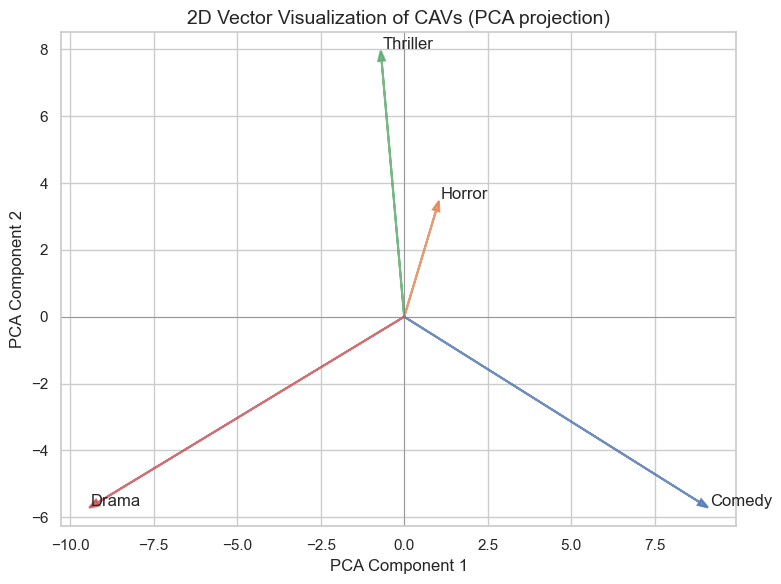

In [36]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot origin
origin = np.array([0, 0])

# Draw arrows from origin to each cav vector
for i, name in enumerate(concept_names):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, name, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.title("2D Vector Visualization of CAVs (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()